In [61]:
import os
import sys
# sys.path.insert(0,'/code/')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.datasets import ImageNet, CIFAR100, CIFAR10, STL10, ImageFolder
import pandas as pd
from torchvision.utils import save_image

import multiprocessing as mp
from tqdm.notebook import tqdm

from datasets.dataset import ImageToHash_Attack

from datasets.imagenette import ImageNette
from metrics.hamming_distance import hamming_distance
from adv3_robustness_check import get_rotation_angles, get_translation_tuples
from utils.transforms import Rotate, Translate, ChangeSaturation, ChangeHue, ChangeContrast, ChangeBrightness, \
    JpegCompression, HorizontalFlipping, BlackBorder, CenterCrop, VerticalFlipping
from scipy.interpolate import griddata

sns.set_style("ticks", {'axes.grid': True})

In [62]:
DATASET = 'coco_val'
TARGET = 'photodna_nn_robust_aug_new_collision'
MAX_ROT_ANGLE = 64
ROT_LOG_BASE = 2
ROT_STEPS = 7
MAX_TRANS = 64
TRANS_LOG_BASE = 2
TRANS_STEPS = 7

HASH_DIR = f'logs/{DATASET}_{TARGET}'
PLOT_DIR = f'robustness_plots/{DATASET}_{TARGET}'
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
EXAMPLE_IMG_CLASS = 'flamingo'
EXAMPLE_IMG_IDX = 2
EXAMPLE_IMG_DIR = f'robustness_plots/{DATASET}/example_imgs'
if not os.path.exists(EXAMPLE_IMG_DIR):
    os.makedirs(EXAMPLE_IMG_DIR)

In [63]:
# def get_dataset(dataset_name: str):
#     # transforms = T.Compose([
#     #     T.Resize((360, 360)),
#     #     T.ToTensor()
#     # ])
#     mean = torch.tensor([0.485, 0.456, 0.406])
#     std = torch.tensor([0.229, 0.224, 0.225])
#     transforms = [
#         T.Resize((64,64)),
#         T.ConvertImageDtype(torch.float32),
#         T.Normalize(mean=mean, std=std)
#     ]
#     if dataset_name.lower() == 'stl10':
#         dataset = STL10(root='data', split='train', download=True, transform=transforms)
#     elif dataset_name.lower() == 'imagenette':
#         dataset = ImageNette(root='data', train=True, download=True, transform=transforms)
#     elif dataset_name.lower() == 'imagenette_val':
#         dataset = ImageNette(root='data', train=False, download=True, transform=transforms)
#     elif dataset_name.lower() == 'cifar10':
#         dataset = CIFAR10(root='data', train=True, download=True, transform=transforms)
#     elif dataset_name.lower() == 'cifar100':
#         dataset = CIFAR100(root='data', train=True, download=True, transform=transforms)
#     elif dataset_name.lower() == 'imagenet_test':
#         dataset = ImageFolder(root='data/ILSVRC2012_test', transform=transforms)
#     elif dataset_name.lower() == 'imagenet_train':
#         dataset = ImageNet(root='data/ILSVRC2012', split='train', transform=transforms)
#     elif dataset_name.lower() == 'imagenet_val':
#         dataset = ImageNet(root='data/ILSVRC2012', split='val', transform=transforms)
#     elif dataset_name.lower() == 'coco_val':
#         dataset = ImageToHash_Attack('../ribosome/coco-val.csv', '../ribosome', transform=transforms)
#     else:
#         raise RuntimeError(f'Dataset with name {dataset_name} was not found.')
# 
#     return dataset

def l1_distance(tensor1, tensor2):
    loss = torch.nn.L1Loss(reduction='sum')
    l1 = []
    for i in range(tensor1.shape[0]):
        l1.append(loss(tensor1[i],tensor2[i]).item())
    return l1

# def get_hashes_from_csv(file_path):
#     df = pd.read_csv(file_path)
#     bin_hashes = []
#     for bit_string in df['hash_bin']:
#         bin_hashes.append(list(bit_string))
#     bin_hashes = np.array(bin_hashes, dtype=int)
# 
#     return bin_hashes

def get_hashes_from_csv(file_path):
    df = pd.read_csv(file_path)
    df['hash_bin'] = df['hash_bin'].apply(lambda x: x.strip('[]').split() if 'nn' in TARGET else x.split())
    df['hash_bin'] = df['hash_bin'].apply(lambda x: [int(i) for i in x])
    bin_hashes = np.array(df['hash_bin'].tolist()).astype(int)
    
    return bin_hashes


def plot_corr_mat(df, min_corr_val=None, max_corr_val=None):
    corr_mat = df.corr()
    corr_values = np.sort(np.unique(corr_mat.values.flatten()))[:-1]
    print(f'Min Corr. Value: {corr_values.min()}')
    print(f'Max Corr. Value: {corr_values.max()}')
    sns.heatmap(
        corr_mat,
        cmap=sns.diverging_palette(250, 15, as_cmap=True),
        vmax=max_corr_val if max_corr_val else corr_values.max(),
        center=0,
        vmin=min_corr_val if min_corr_val else corr_values.min()
    )
    plt.show()


def get_augmented_hashes_and_l1_dist(filenames, augment_values, original_hashes, return_bin_hashes=False, num_processes=2):
    return_hash_dict = {}
    return_l1_dict = {}

    # with tqdm(total=len(filenames)) as pbar:
    with mp.Pool(num_processes) as pool:
        for i, bin_hashes in enumerate(pool.imap(get_hashes_from_csv, filenames)):
            return_hash_dict[augment_values[i]] = bin_hashes
            return_l1_dict[augment_values[i]] = np.array(l1_distance(torch.tensor(bin_hashes), original_hashes))
                # pbar.update()

    if return_bin_hashes:
        return return_hash_dict, return_l1_dict

    return return_l1_dict


def print_mean_and_std_for_keys(given_dict):
    for key in given_dict.keys():
        print(f'Mean L1 Distance for {key}: {given_dict[key].mean()}')
        print(f'Standard Deviation L1 Distance for {key}: {given_dict[key].std()}')
        

def check_for_non_altered_hashes(given_dict, key, return_indices=False):
    non_altered_hash_indices = (given_dict[key] == 0).nonzero()[0]
    print(f'{len(non_altered_hash_indices)} ({float(len(non_altered_hash_indices)) / float(len(given_dict[key])):5.4f}) hashes were not altered when using key {key}')

    if return_indices:
        return non_altered_hash_indices


def plot_example_img_with_transformation(dataset, img_idx, img_class=None, transformation=None, file_path=None):
    if transformation is not None:
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        transforms = [
            T.Resize((64,64)),
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=mean, std=std)
        ]
        dataset.transform = transforms
    base_index = 0
    if img_class is not None:
        base_index = np.argmax(np.array(dataset.targets) == dataset.class_to_idx[img_class])
    img_idx += base_index
    print(f'{dataset.classes[dataset[img_idx][1]][0]}:')
    image = dataset[img_idx][0].permute(1,2,0).numpy()
    plt.imshow(image)
    plt.show()

    if file_path is not None:
        save_image(dataset[img_idx][0], file_path)
        
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    dataset.transform = [
        T.Resize((64,64)),
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=mean, std=std)
    ]


In [64]:
# dataset = get_dataset(DATASET)
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, file_path=os.path.join(EXAMPLE_IMG_DIR, 'original.png'))

In [65]:

bin_hashes_orig = torch.tensor(get_hashes_from_csv(os.path.join(HASH_DIR, f'{DATASET}_original.csv')))

# L_inf Robustness

In [66]:
epsilons = [0.0039, 0.0078, 0.0156, 0.0312]
linf_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'linf_epsilon', f'{DATASET}_linf_epsilon_{epsilon}.csv') for epsilon in epsilons],
    epsilons,
    bin_hashes_orig,
    num_processes=4
)

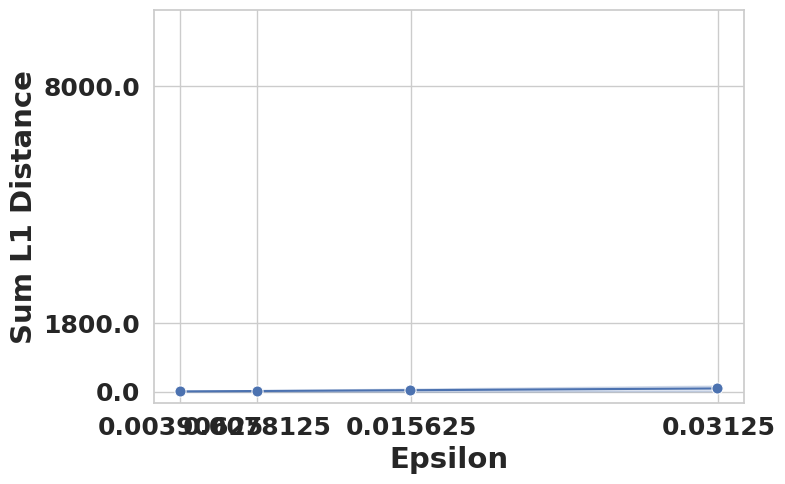

In [67]:
data_expanded = [(angle, value) for angle, values in linf_hamming.items() for value in values]
df = pd.DataFrame(data_expanded, columns=['Epsilon', 'Sum L1 Distance'])
# df = df.melt()

sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Epsilon", y="Sum L1 Distance", errorbar='sd')
fig.set_xlabel("Epsilon", fontsize = 21, fontweight='bold')
fig.set_ylabel("Sum L1 Distance", fontsize = 21, fontweight='bold')
plt.xticks([1/256, 2/256, 4/256, 8/256])
plt.yticks([0.0, 1800, 8000])
plt.ylim(-300, 10000)
# fig.set(ylim=(-300, 0.55))
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_linf_robustness.pdf')

In [68]:
print_mean_and_std_for_keys(linf_hamming)

Mean L1 Distance for 0.0039: 10.6961
Standard Deviation L1 Distance for 0.0039: 12.494956774234955
Mean L1 Distance for 0.0078: 20.4242
Standard Deviation L1 Distance for 0.0078: 21.9181717841612
Mean L1 Distance for 0.0156: 41.7431
Standard Deviation L1 Distance for 0.0156: 41.07941458188031
Mean L1 Distance for 0.0312: 87.9215
Standard Deviation L1 Distance for 0.0312: 75.10269993648697


# Rotation Robustness

In [69]:
# get the rotation angles
angles = get_rotation_angles(MAX_ROT_ANGLE, ROT_LOG_BASE, ROT_STEPS)

In [70]:
rot_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'rotation', f'{DATASET}_rotation_{angle}.csv') for angle in angles],
    angles,
    bin_hashes_orig,
    num_processes=15
)

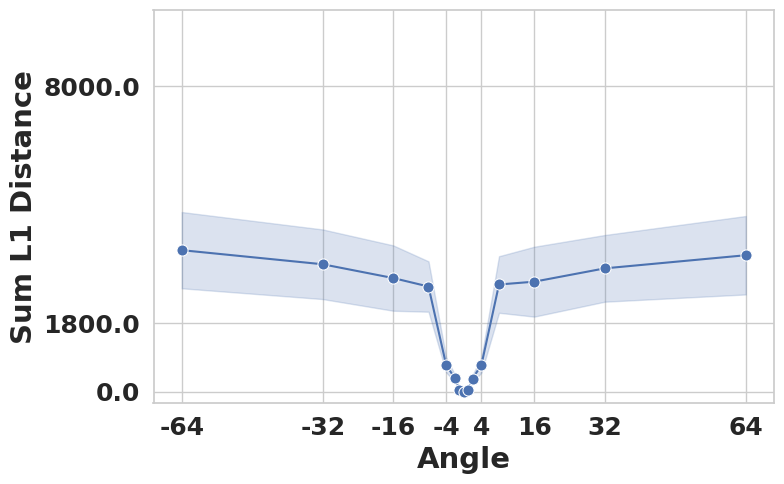

In [71]:
data_expanded = [(angle, value) for angle, values in rot_hamming.items() for value in values]
df = pd.DataFrame(data_expanded, columns=['Angle', 'Sum L1 Distance'])
# df = df.melt()

sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Angle", y="Sum L1 Distance", errorbar='sd')
fig.set_xlabel("Angle", fontsize = 21, fontweight='bold')
fig.set_ylabel("Sum L1 Distance", fontsize = 21, fontweight='bold')
plt.xticks([-64, -32, -16,-4, 4, 16, 32, 64])
plt.yticks([0.0, 1800, 8000])
plt.ylim(-300, 10000)
# fig.set(ylim=(-300, 0.55))
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_rotation_robustness.pdf')

In [72]:
print_mean_and_std_for_keys(rot_hamming)

Mean L1 Distance for -64: 3709.7585
Standard Deviation L1 Distance for -64: 998.5783924047976
Mean L1 Distance for -32: 3340.3199
Standard Deviation L1 Distance for -32: 911.7215612038524
Mean L1 Distance for -16: 2978.8213
Standard Deviation L1 Distance for -16: 855.7595247301138
Mean L1 Distance for -8: 2757.1194
Standard Deviation L1 Distance for -8: 659.7242262821944
Mean L1 Distance for -4: 707.1066
Standard Deviation L1 Distance for -4: 197.48351180906215
Mean L1 Distance for -2: 349.6141
Standard Deviation L1 Distance for -2: 99.23217109985048
Mean L1 Distance for -1: 58.4188
Standard Deviation L1 Distance for -1: 44.81410053275643
Mean L1 Distance for 0: 3.8924
Standard Deviation L1 Distance for 0: 4.250155554800318
Mean L1 Distance for 1: 58.8979
Standard Deviation L1 Distance for 1: 45.59514311404231
Mean L1 Distance for 2: 347.968
Standard Deviation L1 Distance for 2: 100.09531945101129
Mean L1 Distance for 4: 699.4891
Standard Deviation L1 Distance for 4: 197.84078417047888

In [73]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=Rotate(angles[-1]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'rotation.png'))

In [74]:
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(trans_hamming, translations[-1], return_indices=True)
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [75]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=Translate(translations[-1]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'translation.png'))

# Hue Robustness

In [76]:
hues = list(range(-180, 180, 30))
hue_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'hue', f'{DATASET}_hue_{hue}.csv') for hue in hues],
    hues,
    bin_hashes_orig,
    num_processes=12
)

In [77]:
hue_hamming[180] = hue_hamming[-180]

/tmp/ipykernel_3041/3914200584.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig = sns.lineplot(data=df, marker='o', markersize=8, x="HSV Angle", y="Sum L1 Distance", ci='sd')


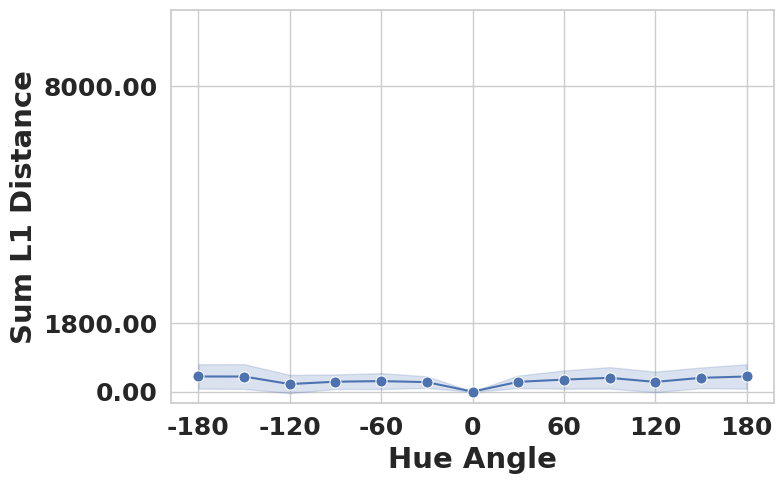

In [78]:
df = pd.DataFrame(hue_hamming)
df = df.melt()
df = df.rename(columns={'variable': 'HSV Angle', 'value': 'Sum L1 Distance'})
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="HSV Angle", y="Sum L1 Distance", ci='sd')
plt.xticks([-180, -120, -60, 0, 60, 120, 180])
plt.yticks([0.0, 1800, 8000])
fig.set_xlabel("Hue Angle", fontsize = 21, fontweight='bold')
fig.set_ylabel("Sum L1 Distance", fontsize = 21, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
plt.ylim(-300, 10000)
yticklabels = []
for item in fig.get_yticklabels():
    fmt = '{:0.2f}'
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]
fig.set_yticklabels(yticklabels)

plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_hue_robustness.pdf')

In [79]:
print_mean_and_std_for_keys(hue_hamming)

Mean L1 Distance for -180: 400.9897
Standard Deviation L1 Distance for -180: 318.97336470920266
Mean L1 Distance for -150: 400.0272
Standard Deviation L1 Distance for -150: 324.51846828826245
Mean L1 Distance for -120: 202.3736
Standard Deviation L1 Distance for -120: 239.38228510698113
Mean L1 Distance for -90: 264.298
Standard Deviation L1 Distance for -90: 189.66020087514406
Mean L1 Distance for -60: 280.1141
Standard Deviation L1 Distance for -60: 208.306526736898
Mean L1 Distance for -30: 253.4353
Standard Deviation L1 Distance for -30: 153.320360728476
Mean L1 Distance for 0: 3.8936
Standard Deviation L1 Distance for 0: 4.250303405640591
Mean L1 Distance for 30: 260.9755
Standard Deviation L1 Distance for 30: 163.71974621208648
Mean L1 Distance for 60: 319.3542
Standard Deviation L1 Distance for 60: 239.73685186545686
Mean L1 Distance for 90: 365.5555
Standard Deviation L1 Distance for 90: 279.66206700185495
Mean L1 Distance for 120: 258.7179
Standard Deviation L1 Distance for 12

In [80]:
check_for_non_altered_hashes(hue_hamming, hues[0])

0 (0.0000) hashes were not altered when using key -180


In [81]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=ChangeHue(hues[0]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'hue.png'))

# Brightness Robustness

In [82]:
brightness_values = list(np.linspace(0, 2, 9, endpoint=True))
brightness_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'brightness', f'{DATASET}_brightness_{int(brightness)}.csv' if 'nn' not in TARGET else f'{DATASET}_brightness_{brightness}.csv') for brightness in brightness_values],
    brightness_values,
    bin_hashes_orig,
    num_processes=9
)

/tmp/ipykernel_3041/2786825443.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig = sns.lineplot(data=df, marker='o', markersize=8, x="Brightness Factor", y="Sum L1 Distance", ci='sd')
/tmp/ipykernel_3041/2786825443.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')


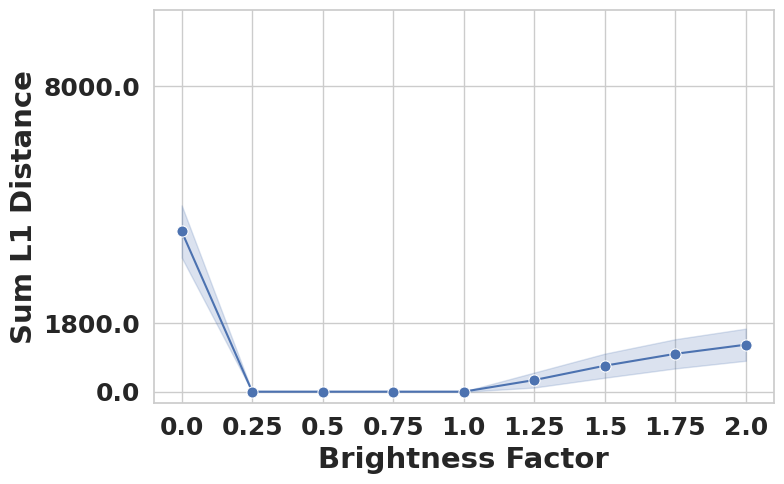

In [83]:
df = pd.DataFrame(brightness_hamming)
df = df.melt()
df = df.rename(columns={'variable': 'Brightness Factor', 'value': 'Sum L1 Distance'})
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Brightness Factor", y="Sum L1 Distance", ci='sd')
plt.yticks([0.0, 1800, 8000])
plt.ylim(-300, 10000)
fig.set(ylabel=None)
# fig.set(ylim=(-300, 0.55))
fig.set_xlabel(fig.get_xlabel(), fontsize = 21, fontweight='bold')
# fig.set_ylabel(fig.get_ylabel(), fontsize = 21, fontweight='bold')
# fig.set_yticklabels([])
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
fig.set_ylabel("Sum L1 Distance", fontsize = 21, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_brightness_robustness.pdf')

In [84]:
print_mean_and_std_for_keys(brightness_hamming)

Mean L1 Distance for 0.0: 4199.3321
Standard Deviation L1 Distance for 0.0: 682.5140193502182
Mean L1 Distance for 0.25: 3.8939
Standard Deviation L1 Distance for 0.25: 4.241891416573508
Mean L1 Distance for 0.5: 3.8948
Standard Deviation L1 Distance for 0.5: 4.247720913619443
Mean L1 Distance for 0.75: 3.8942
Standard Deviation L1 Distance for 0.75: 4.248459292496516
Mean L1 Distance for 1.0: 3.8924
Standard Deviation L1 Distance for 1.0: 4.250155554800318
Mean L1 Distance for 1.25: 307.2692
Standard Deviation L1 Distance for 1.25: 196.33148991274936
Mean L1 Distance for 1.5: 683.2197
Standard Deviation L1 Distance for 1.5: 315.3618642637534
Mean L1 Distance for 1.75: 994.3498
Standard Deviation L1 Distance for 1.75: 382.6130000927308
Mean L1 Distance for 2.0: 1233.614
Standard Deviation L1 Distance for 2.0: 420.88785371402673


In [85]:
check_for_non_altered_hashes(brightness_hamming, brightness_values[-1])

0 (0.0000) hashes were not altered when using key 2.0


In [86]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=ChangeBrightness(brightness_values[-1]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'brightness.png'))

In [87]:
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(brightness_hamming, brightness_values[-1], return_indices=True)[:2]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

# Contrast Robustness

In [88]:
contrast_values = list(np.linspace(0, 2, 9, endpoint=True))
contrast_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'contrast', f'{DATASET}_contrast_{int(contrast)}.csv' if 'nn' not in TARGET else f'{DATASET}_contrast_{contrast}.csv') for contrast in contrast_values],
    contrast_values,
    bin_hashes_orig,
    num_processes=9
)

/tmp/ipykernel_3041/359917586.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig = sns.lineplot(data=df, marker='o', markersize=8, x="Contrast Factor", y="Sum L1 Distance", ci='sd')
/tmp/ipykernel_3041/359917586.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')


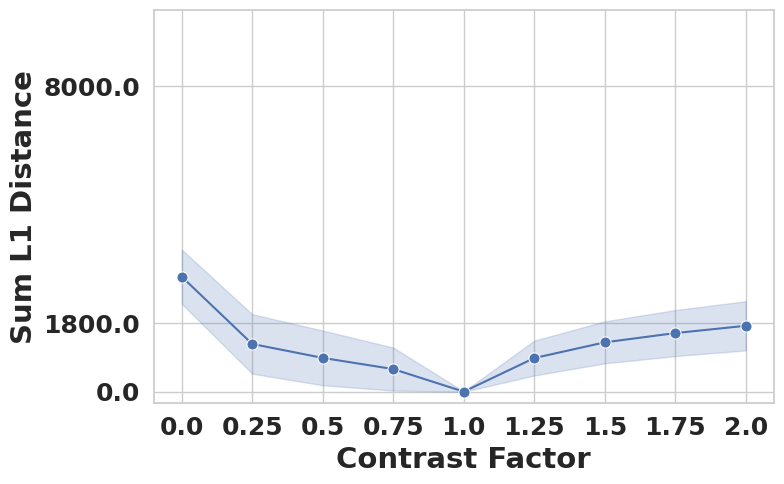

In [89]:
df = pd.DataFrame(contrast_hamming)
df = df.melt()
df = df.rename(columns={'variable': 'Contrast Factor', 'value': 'Sum L1 Distance'})
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Contrast Factor", y="Sum L1 Distance", ci='sd')
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.yticks([0.0, 1800, 8000])
plt.ylim(-300, 10000)
# fig.set(ylabel=None)
# fig.set(ylim=(-300, 0.55))
fig.set_xlabel(fig.get_xlabel(), fontsize = 21, fontweight='bold')
fig.set_ylabel(fig.get_ylabel(), fontsize = 21, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')

plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_contrast_robustness.pdf')

In [90]:
# check_for_non_altered_hashes(contrast_hamming, contrast_values[-1])
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(contrast_hamming, contrast_values[-1], return_indices=True)[:2]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [91]:
print_mean_and_std_for_keys(contrast_hamming)

Mean L1 Distance for 0.0: 3015.2052
Standard Deviation L1 Distance for 0.0: 709.0118930546652
Mean L1 Distance for 0.25: 1253.1263
Standard Deviation L1 Distance for 0.25: 778.4504868958013
Mean L1 Distance for 0.5: 887.7931
Standard Deviation L1 Distance for 0.5: 716.1138530236585
Mean L1 Distance for 0.75: 595.1665
Standard Deviation L1 Distance for 0.75: 563.0724970887408
Mean L1 Distance for 1.0: 3.8924
Standard Deviation L1 Distance for 1.0: 4.250155554800318
Mean L1 Distance for 1.25: 883.4698
Standard Deviation L1 Distance for 1.25: 456.52400340832025
Mean L1 Distance for 1.5: 1295.2434
Standard Deviation L1 Distance for 1.5: 550.3365542615173
Mean L1 Distance for 1.75: 1538.1246
Standard Deviation L1 Distance for 1.75: 602.5582179962696
Mean L1 Distance for 2.0: 1728.6266
Standard Deviation L1 Distance for 2.0: 644.4601791984048


In [92]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=ChangeContrast(contrast_values[-1]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'contrast.png'))

# Saturation Robustness

In [93]:
saturation_values = list(np.linspace(0, 2, 9, endpoint=True))
saturation_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'saturation', f'{DATASET}_saturation_{int(saturation)}.csv' if 'nn' not in TARGET else f'{DATASET}_saturation_{saturation}.csv') for saturation in saturation_values],
    saturation_values,
    bin_hashes_orig,
    num_processes=9
)

/tmp/ipykernel_3041/1452665876.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig = sns.lineplot(data=df, marker='o', markersize=8, x="Saturation Factor", y="Sum L1 Distance", ci='sd')
/tmp/ipykernel_3041/1452665876.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')


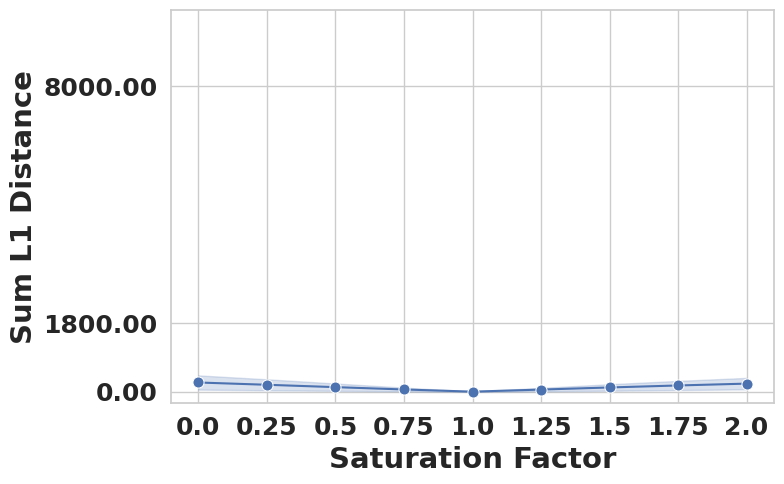

In [94]:
df = pd.DataFrame(saturation_hamming)
df = df.melt()
df = df.rename(columns={'variable': 'Saturation Factor', 'value': 'Sum L1 Distance'})
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Saturation Factor", y="Sum L1 Distance", ci='sd')
plt.yticks([0.0, 1800, 8000])
plt.ylim(-300, 10000)
fig.set_xlabel(fig.get_xlabel(), fontsize = 21, fontweight='bold')
fig.set_ylabel(fig.get_ylabel(), fontsize = 21, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
yticklabels = []
for item in fig.get_yticklabels():
    fmt = '{:0.2f}'
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]
fig.set_yticklabels(yticklabels)

plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_saturation_robustness.pdf')

In [95]:
print_mean_and_std_for_keys(saturation_hamming)

Mean L1 Distance for 0.0: 243.5264
Standard Deviation L1 Distance for 0.0: 186.2599422931297
Mean L1 Distance for 0.25: 183.8645
Standard Deviation L1 Distance for 0.25: 143.7879172244664
Mean L1 Distance for 0.5: 121.9625
Standard Deviation L1 Distance for 0.5: 95.59287784008806
Mean L1 Distance for 0.75: 60.6214
Standard Deviation L1 Distance for 0.75: 49.0029393204122
Mean L1 Distance for 1.0: 3.8924
Standard Deviation L1 Distance for 1.0: 4.250155554800318
Mean L1 Distance for 1.25: 58.1946
Standard Deviation L1 Distance for 1.25: 44.560575970694096
Mean L1 Distance for 1.5: 113.6404
Standard Deviation L1 Distance for 1.5: 84.57618156336925
Mean L1 Distance for 1.75: 165.7099
Standard Deviation L1 Distance for 1.75: 120.17812921655089
Mean L1 Distance for 2.0: 214.1953
Standard Deviation L1 Distance for 2.0: 150.17927406240184


In [96]:
# check_for_non_altered_hashes(saturation_hamming, saturation_values[-1])
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(saturation_hamming, saturation_values[-1], return_indices=True)[:2]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [97]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=ChangeSaturation(saturation_values[-1]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'saturation.png'))

# Compression Robustness

In [98]:
compression_values = [100] + list(
    (100 - np.ceil(np.logspace(0, np.log(100) / np.log(1.5), 10, endpoint=True, base=1.5))).clip(0, 100)
)
print(compression_values)
compression_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'compression', f'{DATASET}_compression_{int(compression)}.csv' if 'nn' not in TARGET else f'{DATASET}_compression_{compression}.csv') for compression in compression_values],
    compression_values,
    bin_hashes_orig,
    num_processes=11
)
print(compression_hamming)

[100, 99.0, 98.0, 97.0, 95.0, 92.0, 87.0, 78.0, 64.0, 40.0, 0.0]
{100: array([2211, 2149, 2106, ..., 3386, 2383, 1788]), 99.0: array([2113, 1927, 2148, ..., 2718, 2365, 2350]), 98.0: array([2325, 2218, 1640, ..., 2259, 1882, 1544]), 97.0: array([1474, 1095, 1618, ..., 2063, 1702, 1370]), 95.0: array([1243, 1053, 1209, ..., 1595, 1109, 1200]), 92.0: array([ 948, 1070,  985, ..., 1884, 1886, 1090]), 87.0: array([884, 536, 621, ..., 614, 612, 664]), 78.0: array([461, 440, 467, ..., 444, 448, 434]), 64.0: array([368, 338, 465, ..., 366, 348, 303]), 40.0: array([223, 200, 266, ..., 292, 305, 208]), 0.0: array([48, 53, 44, ..., 52, 87, 70])}


/tmp/ipykernel_3041/740927890.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig = sns.lineplot(data=df, marker='o', markersize=8, x="Compression Value", y="Sum L1 Distance", ci='sd')


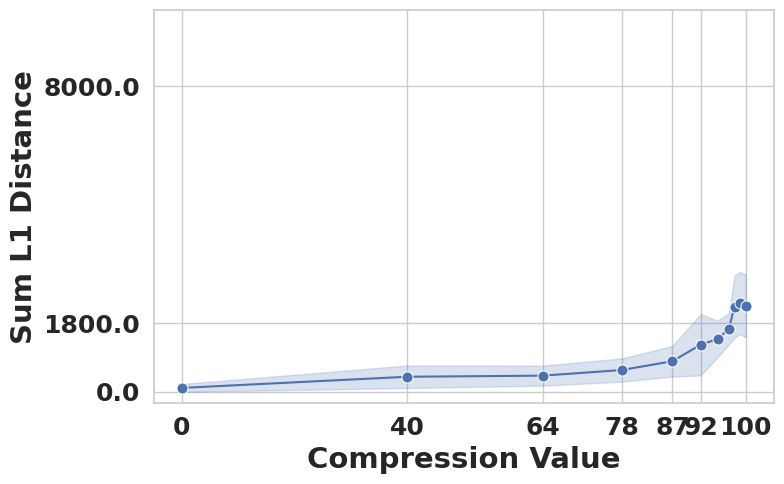

In [99]:
df = pd.DataFrame(compression_hamming)
df = df.melt()
df = df.rename(columns={'variable': 'Compression Value', 'value': 'Sum L1 Distance'})
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Compression Value", y="Sum L1 Distance", ci='sd')
plt.xticks([0, 40, 64, 78, 87, 92, 100])
plt.yticks([0.0, 1800, 8000])
plt.ylim(-300, 10000)
fig.set_xlabel(fig.get_xlabel(), fontsize = 21, fontweight='bold')
fig.set_ylabel(fig.get_ylabel(), fontsize = 21, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')


plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_compression_robustness.pdf')

In [100]:
print_mean_and_std_for_keys(compression_hamming)

Mean L1 Distance for 100: 2248.7523
Standard Deviation L1 Distance for 100: 823.7469161973901
Mean L1 Distance for 99.0: 2323.3905
Standard Deviation L1 Distance for 99.0: 820.3634056988099
Mean L1 Distance for 98.0: 2233.8241
Standard Deviation L1 Distance for 98.0: 812.8541645087328
Mean L1 Distance for 97.0: 1650.9478
Standard Deviation L1 Distance for 97.0: 409.3292702399377
Mean L1 Distance for 95.0: 1382.1155
Standard Deviation L1 Distance for 95.0: 476.96389481778385
Mean L1 Distance for 92.0: 1233.8518
Standard Deviation L1 Distance for 92.0: 803.9179062794658
Mean L1 Distance for 87.0: 800.3517
Standard Deviation L1 Distance for 87.0: 399.8156737886973
Mean L1 Distance for 78.0: 569.8523
Standard Deviation L1 Distance for 78.0: 304.15614786604266
Mean L1 Distance for 64.0: 423.2281
Standard Deviation L1 Distance for 64.0: 262.95013609121787
Mean L1 Distance for 40.0: 394.1711
Standard Deviation L1 Distance for 40.0: 295.4041042788505
Mean L1 Distance for 0.0: 101.7227
Standard

In [101]:
# check_for_non_altered_hashes(compression_hamming, compression_values[5])
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(compression_hamming, compression_values[5], return_indices=True)[-2:]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [102]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=JpegCompression(compression_values[5]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'compression.png'))

# Crop Robustness

In [103]:
crop_values = list(
    filter(
        lambda x: x != 63,  # Change this value if you specifically want to exclude a different size
        [64] + list(64 - np.append(np.logspace(0, 5, 6, base=2, endpoint=True, dtype=int), [32]))
    )
)
crop_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'crop', f'{DATASET}_crop_{int(crop)}.csv' if 'nn' not in TARGET else f'{DATASET}_crop_{crop}.csv') for crop in crop_values],
    crop_values,
    bin_hashes_orig,
    num_processes=10
)


/tmp/ipykernel_3041/3821098543.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig = sns.lineplot(data=df, marker='o', markersize=8, x="Center Crop Size", y="Sum L1 Distance", ci='sd')


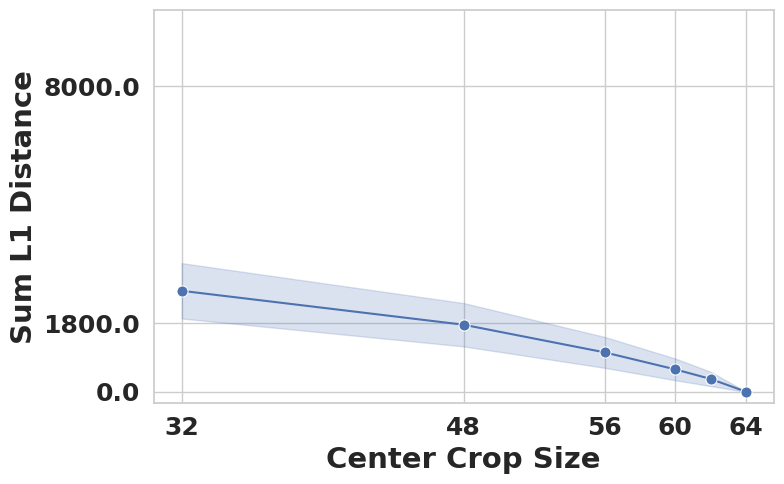

In [104]:
df = pd.DataFrame(crop_hamming)
df = df.melt()
df = df.rename(columns={'variable': 'Center Crop Size', 'value': 'Sum L1 Distance'})
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Center Crop Size", y="Sum L1 Distance", ci='sd')
plt.xticks([64, 60, 56, 48, 32])
plt.yticks([0.0, 1800, 8000])
plt.ylim(-300, 10000)
# fig.invert_xaxis()
fig.set_xlabel(fig.get_xlabel(), fontsize = 21, fontweight='bold')
fig.set_ylabel(fig.get_ylabel(), fontsize = 21, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')

plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_crop_robustness.pdf')

In [105]:
print_mean_and_std_for_keys(crop_hamming)

Mean L1 Distance for 64: 3.8924
Standard Deviation L1 Distance for 64: 4.250155554800318
Mean L1 Distance for 62: 337.2223
Standard Deviation L1 Distance for 62: 187.14691790865805
Mean L1 Distance for 60: 587.1609
Standard Deviation L1 Distance for 60: 284.2722188522649
Mean L1 Distance for 56: 1032.1212
Standard Deviation L1 Distance for 56: 404.1276685783343
Mean L1 Distance for 48: 1756.2658
Standard Deviation L1 Distance for 48: 567.2741493760843
Mean L1 Distance for 32: 2645.0608
Standard Deviation L1 Distance for 32: 724.846809542099


In [106]:
# check_for_non_altered_hashes(crop_hamming, crop_values[-2])
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(crop_hamming, crop_values[-2], return_indices=True)[:2]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [107]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=CenterCrop(crop_values[-2]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'crop.png'))

# Horizontal Flipping Robustness

In [108]:
hflip_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'hflip', f'{DATASET}_hflip.csv')],
    [0],
    bin_hashes_orig,
    num_processes=1
)

In [109]:
print(f'AVE Sum L1 Distance: {hflip_hamming[0].mean()}')
print(f'Standard Deviation Sum L1 Distance: {hflip_hamming[0].std()}')

AVE Sum L1 Distance: 2210.973
Standard Deviation Sum L1 Distance: 684.2252065445996


In [110]:
# check_for_non_altered_hashes(hflip_hamming, 0)
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(hflip_hamming, 0, return_indices=True)[:2]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [111]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=HorizontalFlipping(), file_path=os.path.join(EXAMPLE_IMG_DIR, 'hflip.png'))

# Vertical Flipping Robustness

In [112]:
vflip_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'vflip', f'{DATASET}_vflip.csv')],
    [0],
    bin_hashes_orig,
    num_processes=1
)

In [113]:
print(f'Average Sum L1 Distance: {vflip_hamming[0].mean()}')
print(f'Standard Deviation Sum L1 Distance: {vflip_hamming[0].std()}')

Average Sum L1 Distance: 2869.8332
Standard Deviation Sum L1 Distance: 830.5880297582911


In [114]:
# check_for_non_altered_hashes(vflip_hamming, 0)
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(vflip_hamming, 0, return_indices=True)[:2]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [115]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=VerticalFlipping(), file_path=os.path.join(EXAMPLE_IMG_DIR, 'vflip.png'))

# Downsizing Robustness

In [116]:
downsizing_values = list(
    filter(
        lambda x: x != 63,  # Ensure consistency in what's being excluded
        [64] + list(64 - np.append(np.logspace(0, 5, 6, base=2, endpoint=True, dtype=int), [32]))
    )
)
downsizing_hamming = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'downsizing', f'{DATASET}_downsizing_{size}.csv') for size in downsizing_values],
    downsizing_values,
    bin_hashes_orig,
    num_processes=9
)

/tmp/ipykernel_3041/3810046213.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig = sns.lineplot(data=df, marker='o', markersize=8, x="Image Size", y="Sum L1 Distance", ci='sd')


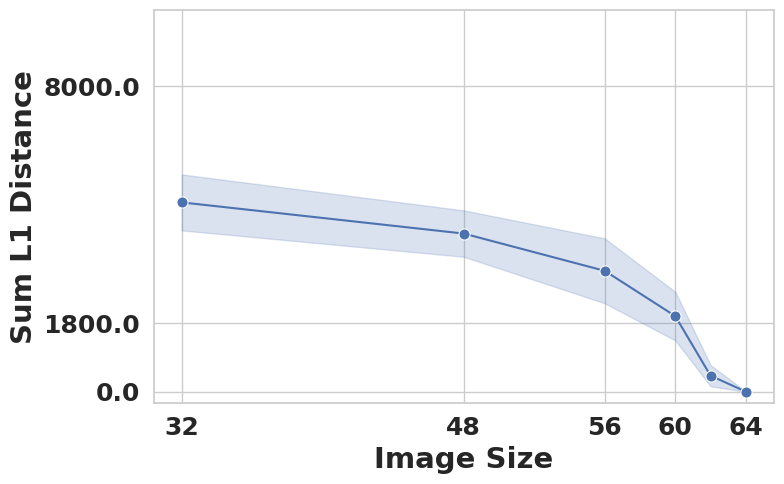

In [117]:
df = pd.DataFrame(downsizing_hamming)
df = df.melt()
df = df.rename(columns={'variable': 'Image Size', 'value': 'Sum L1 Distance'})
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
fig = sns.lineplot(data=df, marker='o', markersize=8, x="Image Size", y="Sum L1 Distance", ci='sd')
fig.invert_xaxis()
plt.ylim(-300, 10000)
plt.xticks([64, 60, 56, 48, 32])
# plt.xticks([32, 48, 56, 60, 64])
plt.yticks([0.0, 1800, 8000])
fig.invert_xaxis()
fig.set_xlabel(fig.get_xlabel(), fontsize = 21, fontweight='bold')
fig.set_ylabel(fig.get_ylabel(), fontsize = 21, fontweight='bold')
fig.set_yticklabels(fig.get_yticks(), size = 18, fontweight='bold')
fig.set_xticklabels(fig.get_xticks(), size = 18, fontweight='bold')
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_downsizing_robustness.pdf')

In [118]:
print_mean_and_std_for_keys(downsizing_hamming)

Mean L1 Distance for 64: 3.8924
Standard Deviation L1 Distance for 64: 4.250155554800318
Mean L1 Distance for 62: 422.2044
Standard Deviation L1 Distance for 62: 276.76029379345584
Mean L1 Distance for 60: 1982.5206
Standard Deviation L1 Distance for 60: 636.5478508137782
Mean L1 Distance for 56: 3168.0939
Standard Deviation L1 Distance for 56: 849.4407644343365
Mean L1 Distance for 48: 4144.3862
Standard Deviation L1 Distance for 48: 607.3228380767185
Mean L1 Distance for 32: 4960.8547
Standard Deviation L1 Distance for 32: 732.9886664798507


In [119]:
# check_for_non_altered_hashes(downsizing_hamming, downsizing_values[1])
# # plot two images that do not change
# idx1, idx2 = check_for_non_altered_hashes(downsizing_hamming, downsizing_values[1], return_indices=True)[:2]
# print(f'{dataset.classes[dataset[idx1][1]][0]}:')
# plt.imshow(dataset[idx1][0].permute(1,2,0))
# plt.show()
# print(f'{dataset.classes[dataset[idx2][1]][0]}:')
# plt.imshow(dataset[idx2][0].permute(1,2,0))
# plt.show()

In [120]:
# plot_example_img_with_transformation(dataset, EXAMPLE_IMG_IDX, img_class=EXAMPLE_IMG_CLASS, transformation=BlackBorder(downsizing_values[-1]), file_path=os.path.join(EXAMPLE_IMG_DIR, 'downsizing.png'))